# 2 Data wrangling<a id='2_Data_wrangling'></a>

## 2.1 Contents<a id='2.1_Contents'></a>
* [2 Data wrangling](#2_Data_wrangling)
  * [2.1 Contents](#2.1_Contents)
  * [2.2 Introduction](#2.2_Introduction)
  * [2.3 Imports](#2.3_Imports)
  * [2.4 Objectives](#2.4_Objectives)
  * [2.5 Load The Perfume Data](#2.5_Load_The_Perfume_Data)
  * [2.6 Explore The Data](#2.6_Explore_The_Data)
    * [2.6.1 Create Profile Report for the dataset](#2.6.1_Create_profile_report)
    * [2.6.2 Number Of Missing Values By Column](#2.6.2_Number_Of_Missing_Values_By_Column)
    * [2.6.3 Categorical Features](#2.6.3_Categorical_Features)
    * [2.6.4 Numeric Features](#2.6.4_Numeric_Features)
    * [2.6.5 Check for Duplicates](#2.6.5_Check_Duplicates)
  * [2.7 Target Feature](#2.7_Target_Feature)
  * [2.8 Cleanup Dataset](#2.8_Cleanup_Dataset)
  * [2.9 Save data](#2.9_Save_data)
  * [2.10 Summary](#2.10_Summary)


## 2.2 Introduction<a id='2.2_Introduction'></a>

The purpose of this data science project is to classify a given perfume to a gender that would receive it the best.

This will help the New Sense Company to market their perfume to the right crowd.

## 2.3 Imports<a id='2.3_Imports'></a>

In [301]:
#importing ds packages
import pandas as pd
import numpy as np
import re 

import pandas_profiling

In [302]:
# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

## 2.4 Objectives<a id='2.4_Objectives'></a>

There are some fundamental questions to resolve in this notebook before you move on.

Fragrantica website is a place where people can vote on various perfumes.

They can evaluate the following features of a perfume

 - longevity (very long/long/moderate/weak/poor)
 - sillage (soft/moderate/heavy/enormous)
 - love/like/dislike
 - perfume suited for?
   - day/night?
   - spring/summer/autumn/winter
   - male/female
 - had it/have it/want it

Based on the above selections a `rating score` is calculated. `No. of votes` received per perfume is also maintained.

For each perfume, Fragrantica also maintains the following information as received from the manufacturers.
 - Brand
 - Name
 - Released Year
 - main accords
 - notes

We can do a two fold study of this data.

1. A Descriptive Analysis: Given all the opinion data we have collected, we can analyze it to determine which perfume are the most popular and how the perceived sillage and longevity of it affects its rating with customers. This will help us make a decision on what kind of perfume to create.

2. An Inferential Analysis: We can use the same data to predict how a new perfume will be received by a particular gender and age group.

In this notebook, we are planning to do the second.

## 2.5 Load The Perfume Data<a id='2.5_Load_The_Perfume_Data'></a>

In [303]:
# importing the data
orig_df = pd.read_csv('../data/raw/perfume.csv')#, nrows=5000)

df = orig_df.copy()

In [304]:
df.shape

(51212, 86)

In [305]:
pd.options.display.max_rows = 100

## 2.6 Explore The Data<a id='2.6_Explore_The_Data'></a>

### 2.6.1 Check for Data Type Constraints<a id='2.6.1_Datatype_Constraints'></a>

Let's look at the columns.

In [306]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51212 entries, 0 to 51211
Data columns (total 86 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   brand                     51212 non-null  object 
 1   title                     51212 non-null  object 
 2   date                      51212 non-null  int64  
 3   accords                   50268 non-null  object 
 4   rating_score              51212 non-null  float64
 5   votes                     51212 non-null  int64  
 6   longevity_poor            51212 non-null  int64  
 7   longevity_weak            51212 non-null  int64  
 8   longevity_moderate        51212 non-null  int64  
 9   longevity_long            51212 non-null  int64  
 10  longevity_very_long       51212 non-null  int64  
 11  sillage_soft              51212 non-null  int64  
 12  sillage_moderate          51212 non-null  int64  
 13  sillage_heavy             51212 non-null  int64  
 14  sillag

In [307]:
df.head()

,brand,title,date,accords,rating_score,votes,longevity_poor,longevity_weak,longevity_moderate,longevity_long,...,notes_12,notes_13,notes_14,notes_15,notes_16,notes_17,notes_18,notes_19,notes_20,gender
0,The-Spirit-of-Dubai,Aamal The Spirit of Dubai for women and men,2017,"woody,earthy,animalic,amber,musky,balsamic",5.0,3,0,0,0,0,...,Base3Moss,Base4Agarwood (Oud),Base5Indian Oud,NaN,NaN,NaN,NaN,NaN,NaN,women
1,Ajmal,Aatifa Ajmal for women and men,2014,"fresh spicy,woody,musky,rose,amber",4.2,10,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
2,Al-Jazeera-Perfumes,AA Al-Jazeera Perfumes for women and men,0,"rose,woody,musky,oud,fruity",0.0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
3,Art-of-Scent-Swiss-Perfumes,aarewasser Art of Scent - Swiss Perfumes for w...,2010,"white floral,green,ozonic,fresh,animalic",0.0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
4,Hamidi-Oud-Perfumes,Aaliyah Hamidi Oud & Perfumes for women and men,0,"woody,warm spicy,amber,balsamic,musky",0.0,2,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women


There are no problems in the data types of the fields.

### 2.6.2 Check for Data Range Constraints<a id='2.6.2_Datarange_Constraints'></a>

In [308]:
# Check numerical fields
df.describe().T

,count,mean,std,min,25%,50%,75%,max
date,51212.0,1526.492775,867.219020,0.0,1900.0,2009.00,2015.00,9459.0
rating_score,51212.0,3.192377,1.630846,0.0,3.0,3.86,4.20,5.0
votes,51212.0,86.440522,362.674407,0.0,2.0,9.00,42.00,11188.0
longevity_poor,51212.0,1.883230,6.636540,-1.0,0.0,0.00,1.00,427.0
longevity_weak,51212.0,2.458252,8.809443,-2.0,0.0,0.00,2.00,364.0
longevity_moderate,51212.0,6.665450,27.960634,0.0,0.0,1.00,4.00,1124.0
longevity_long,51212.0,6.477974,34.181818,0.0,0.0,0.00,3.00,1421.0
longevity_very_long,51212.0,3.544931,22.603463,0.0,0.0,0.00,2.00,1258.0
sillage_soft,51212.0,4.870558,17.328103,-1.0,0.0,1.00,3.00,906.0
sillage_moderate,51212.0,10.671171,43.066644,0.0,0.0,1.00,6.00,1815.0


`date` field has extreme values.

In [309]:
np.sort(df.date.unique())

array([   0,    1,   69,  101,  102,  103,  104,  105,  106,  613,  773,
       1000, 1001, 1002, 1003, 1004, 1005, 1006, 1015, 1028, 1030, 1036,
       1050, 1060, 1070, 1100, 1117, 1144, 1150, 1175, 1177, 1178, 1195,
       1200, 1214, 1221, 1224, 1240, 1250, 1258, 1260, 1265, 1270, 1279,
       1300, 1315, 1319, 1350, 1400, 1414, 1443, 1447, 1452, 1475, 1499,
       1500, 1503, 1533, 1538, 1555, 1561, 1569, 1597, 1598, 1599, 1600,
       1605, 1606, 1610, 1614, 1619, 1623, 1650, 1651, 1652, 1658, 1660,
       1667, 1672, 1673, 1680, 1681, 1691, 1695, 1697, 1700, 1707, 1709,
       1717, 1718, 1719, 1725, 1730, 1738, 1740, 1747, 1750, 1752, 1758,
       1759, 1760, 1767, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1779,
       1780, 1781, 1786, 1792, 1793, 1795, 1798, 1799, 1800, 1801, 1802,
       1803, 1804, 1805, 1806, 1807, 1808, 1810, 1811, 1812, 1814, 1815,
       1818, 1819, 1820, 1821, 1823, 1826, 1828, 1830, 1831, 1832, 1833,
       1834, 1837, 1840, 1841, 1842, 1843, 1844, 18

It is not possible to have perfumes with such old dates. Let's take a look at perfumes created after 1950.

In [310]:
# How many perfumes have an year between acceptable range?
date_ok_df = df[(df.date >= 1950) & (df.date < 2020)]

len(date_ok_df)/len(df)*100

73.3089900804499

73% of the perfumes have a valid year. So we need to clean up the other data. 

Lets find the `Median` and `Mode` of the dataset after filtering out outlier values for the `date` field.

In [311]:
date_ok_df.date.median(), date_ok_df.date.mode()

(2013.0,
 0    2017
 dtype: int64)

To even out the years, we can use both Median and Mode values to clean up data. This will make sure that no one year gets too heavily influenced.

In [312]:
#np.sort(df[df.date < 1950].date.unique())
df[df.date < 1950].date.value_counts()

0       12237
1920      103
1833       45
1000       41
1930       39
        ...  
1819        1
1843        1
1867        1
1004        1
1028        1
Name: date, Length: 243, dtype: int64

Set `date = 2013` for all perfumes where the `date` value is `0` and set `date = 2017` for all other perfumes with out of range values.

In [313]:
# Repalce with Median
df['date'] = df.date.replace(0, 2013)

In [314]:
# Replace with Mode
years_to_replace =df[df.date > 2020 ].date.append(df[df.date < 1950].date)

df['date'] = df.date.replace(years_to_replace.values, 2017) 

In [315]:
# Check teh date range
np.sort(df.date.unique())

array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020], dtype=int64)

In [316]:
# Rename `date` as `release_year`
df.rename(columns = {'date':'release_year'}, inplace = True) 

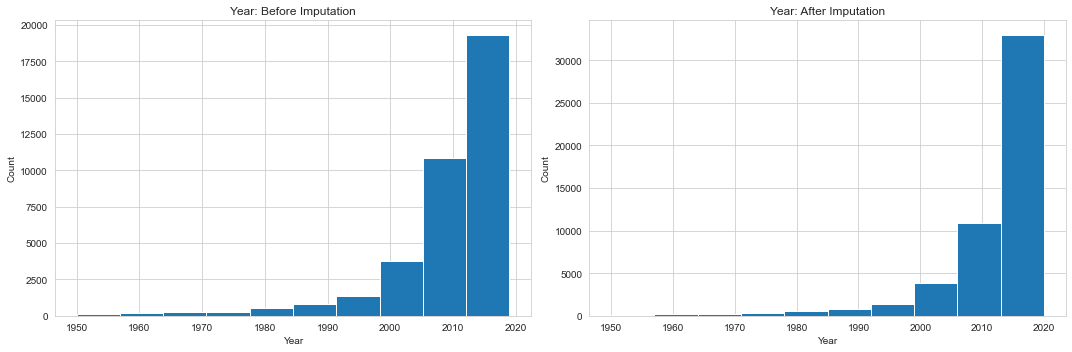

In [317]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.hist(date_ok_df.date)
plt.title('Year: Before Imputation')  
plt.xlabel('Year'); plt.ylabel('Count')


plt.subplot(1,2,2)
plt.hist(df.release_year)
plt.title('Year: After Imputation')  
plt.xlabel('Year'); plt.ylabel('Count')

plt.tight_layout()
plt.show();

The fields `longevity_poor`, `longevity_weak`, `sillage_soft`, `sillage_heavy` have a negative _min_ value. This is out of range.

In [318]:
# Set the `min` value as `0`
df.longevity_poor.clip(lower=0, inplace=True)
df.longevity_weak.clip(lower=0, inplace=True)
df.sillage_soft.clip(lower=0, inplace=True)
df.sillage_heavy.clip(lower=0, inplace=True)

### 2.6.3 Clean up data<a id='2.6.3_Clean_Data'></a>

This dataset contains the survey details of different perfumes. It has a field which denotes the number of votes received per perfume. From a business point of view, we prefer to only look at perfumes that have garnered at least 100 votes or more. They would be the most popular perfumes and we prefer to study them.

In [319]:
# What % of perfumes have votes > 100
len(df[df.votes>100])/len(df)*100

14.297430289775834

We only have _14%_ of perfumes with votes > 100. What if we bring it down to 50?

In [320]:
# What % of perfumes have votes > 50
len(df[df.votes>50])/len(df)*100

22.41857377177224

Not much of an increase - just _22%_ of perfumes have votes > 50. What if we bring it down to 10?

In [321]:
# What % of perfumes have votes > 10
len(df[df.votes>=10])/len(df)*100

48.76591423885027

This has given us 48% of perfumes. Let's go with that. We can drop all perfumes with votes less than 10.

In [322]:
df.drop(df[df.votes<10].index, inplace=True)

The `sillage` and `longevity` are features that are voted on a scale. At present their values are split across columns. It would be better to receive a single value for a perfume.

In [323]:
df[['sillage_soft', 'sillage_moderate', 'sillage_heavy', 'sillage_enormous']]

,sillage_soft,sillage_moderate,sillage_heavy,sillage_enormous
1,0,0,3,3
5,2,2,1,4
7,1,4,3,0
8,0,7,2,1
9,0,4,2,1
...,...,...,...,...
51196,3,3,4,4
51197,0,5,6,2
51198,0,3,2,2
51200,0,3,2,0


In [324]:
df['sillage'] = df[['sillage_soft', 'sillage_moderate', 'sillage_heavy', 'sillage_enormous']].idxmax(axis=1)

In [325]:
df['sillage'] = df['sillage'].replace(['sillage_soft', 'sillage_moderate', 'sillage_heavy', 'sillage_enormous'],[1,2,3,4])

In [326]:
df.drop(columns=['sillage_soft', 'sillage_moderate', 'sillage_heavy', 'sillage_enormous'], axis =1 , inplace=True)

In [327]:
df[['longevity_poor', 'longevity_weak', 'longevity_moderate', 'longevity_long', 'longevity_very_long']]

,longevity_poor,longevity_weak,longevity_moderate,longevity_long,longevity_very_long
1,1,0,0,0,5
5,0,0,1,2,1
7,0,1,1,3,0
8,0,2,1,4,1
9,0,0,2,1,0
...,...,...,...,...,...
51196,0,5,3,0,1
51197,0,0,2,4,0
51198,0,0,5,1,0
51200,0,0,0,1,2


In [328]:
df['longevity'] = df[['longevity_poor', 'longevity_weak', 'longevity_moderate', 'longevity_long', 'longevity_very_long']].idxmax(axis=1)
df['longevity'] = df['longevity'].replace(['longevity_poor', 'longevity_weak', 'longevity_moderate', 'longevity_long', 'longevity_very_long'],[1,2,3,4,5])

In [329]:
df.drop(columns=['longevity_poor', 'longevity_weak', 'longevity_moderate', 'longevity_long', 'longevity_very_long'], axis =1 , inplace=True)

We are only planning to look at the Gender preference for each perfume. Hence we do not need the survey responses on the season of preference for a perfume.

Let's drop the columns related to them.

In [330]:
cols_to_drop = ['clsdislike', 'clsdislike_female25under', 'clsdislike_male25under', 'clsdislike_female25older', 'clsdislike_male25older', 
                'clswinter', 'clswinter_female25under', 'clswinter_male25under', 'clswinter_female25older', 'clswinter_male25older', 
                'clsspring', 'clsspring_female25under', 'clsspring_male25under', 'clsspring_female25older', 'clsspring_male25older',
                'clssummer', 'clssummer_female25under', 'clssummer_male25under', 'clssummer_female25older', 'clssummer_male25older', 
                'clsautumn', 'clsautumn_female25under', 'clsautumn_male25under', 'clsautumn_female25older', 'clsautumn_male25older', 
                'clsday', 'clsday_female25under', 'clsday_male25under', 'clsday_female25older', 'clsday_male25older', 
                'clsnight', 'clsnight_female25under', 'clsnight_male25under', 'clsnight_female25older', 'clsnight_male25older',
                'clscold', 'clshot']

df.drop(columns=cols_to_drop, axis =1 , inplace=True)

In [331]:
df.shape

(24974, 42)

### 2.6.4 Check for Duplicates<a id='2.6.4_Check_Duplicates'></a>

In [332]:
df.duplicated().sum()

0

There are no duplicates across the entire dataframe.

Let's check if there are duplicates when taking `brand`, `title` together.

In [333]:
df[df.duplicated(['brand', 'title'])].shape

(28, 42)

There are 28 rows. What if we were to add the fields `release_year`?

In [334]:
df[df.duplicated(['brand', 'title', 'release_year'])].shape

(10, 42)

10 rows. Let's review one of them.

In [335]:
df[df.duplicated(['brand', 'title', 'release_year'])]

,brand,title,release_year,accords,rating_score,votes,clslove,clslike,clslove_female25under,clslove_male25under,...,notes_14,notes_15,notes_16,notes_17,notes_18,notes_19,notes_20,gender,sillage,longevity
482,Loewe,Quizas,2007,"fruity,white floral,patchouli,sweet,aromatic,w...",3.94,377,84,100,18,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,4
10650,Mancera,Black Intensitive Aoud Mancera for women and men,2008,"woody,warm spicy,rose,oud,fresh spicy,powdery",3.67,14,75,100,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,5
16562,Pryn-Parfum,Ayothaya Pryn Parfum for women and men,2017,"woody,balsamic,smoky,warm spicy,sweet",3.85,14,100,42,1,1,...,Top14Lichen,Top15Ylang-Ylang,Top16Jasmine Sambac,Middle0nan,Base0nan,NaN,NaN,women,3,3
22091,Caron,Or et Noir Caron for women,2017,"rose,floral,amber,fresh,green,Pictures",3.63,11,100,100,1,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women,2,3
33712,Caron,French Cancan Caron for women,2017,"white floral,powdery,woody,rose,amber,floral,P...",5.00,10,100,1,1,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women,1,3
36901,Caron,Fleurs de Rocaille Caron for women,2017,"floral,woody,powdery,aldehydic,yellow floral,P...",4.51,59,100,40,8,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women,2,3
37630,Caron,Farnesiana Caron for women,2017,"powdery,floral,yellow floral,sweet,woody,Pictures",4.00,10,60,100,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women,1,3
39882,Guerlain,La Petite Robe Noire Guerlain for women,2009,"sweet,soft spicy,almond,vanilla,gourmand,Pictures",3.17,536,78,89,14,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women,2,3
42167,Guerlain,Shalimar Extrait Guerlain for women,2017,"floral,powdery,citrus,rose,vanilla,aromatic,Pi...",2.92,16,66,50,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women,1,1
46332,Jean-Patou,1000 Jean Patou for women,2017,"floral,powdery,woody,fruity,rose,Pictures",4.09,623,100,65,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women,2,4


In [336]:
df[df.title == 'Quizas']

,brand,title,release_year,accords,rating_score,votes,clslove,clslike,clslove_female25under,clslove_male25under,...,notes_14,notes_15,notes_16,notes_17,notes_18,notes_19,notes_20,gender,sillage,longevity
237,Loewe,Quizas,2007,"fruity,citrus,sweet,floral,woody,Pictures",3.85,170,68,100,28,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3
482,Loewe,Quizas,2007,"fruity,white floral,patchouli,sweet,aromatic,w...",3.94,377,84,100,18,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,4


They differ on `accords` field. So let's add `accords` to our filter criteria.

In [337]:
df[df.duplicated(['brand', 'title', 'release_year', 'accords'])].shape

(0, 42)

There are no duplicated rows.

#### 2.6.5 Review Categorical Featrures<a id='2.6.5_Categorical_Features'></a>

In [338]:
df.select_dtypes('object')

,brand,title,accords,notes_1,notes_2,notes_3,notes_4,notes_5,notes_6,notes_7,...,notes_12,notes_13,notes_14,notes_15,notes_16,notes_17,notes_18,notes_19,notes_20,gender
1,Ajmal,Aatifa Ajmal for women and men,"fresh spicy,woody,musky,rose,amber",Top1Rose,Top2Cumin,Middle0Amber,Middle1Woody Notes,Base0Musk,Base1Amber,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
5,Xyrena,Aaliyah Xyrena for women and men,"powdery,fresh spicy,aromatic,woody,leather,flo...",Top1Lavender,Top2Mint,Middle0Violet,Middle1Leather,Middle2Black Pepper,Base0Sandalwood,Base1Jasmine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
7,source-adage-NYC,c’i'aan source adage NYC for women and men,"woody,aromatic,fresh spicy,green,fresh",Top1Mint,Top2Apple,Top3Fir,Top4Cedar,Top5Amber,Middle0nan,Base0nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
8,Blackbird,Targa Blackbird for women and men,"balsamic,woody,smoky,fresh spicy,warm spicy",Top1Citruses,Top2Green Pepper,Top3Olibanum,Top4Opoponax,Top5Geranium,Top6Caraway,Middle0Black Pepper,...,Middle5Nutmeg,Base0Sandalwood,Base1Agarwood (Oud),Base2Incense,Base3Guaiac Wood,Base4Teak Wood,Base5Cedar,Base6Oak,Base7Vetiver,women
9,Blackbird,Broken Glass Blackbird for women and men,"herbal,aromatic,musky,fresh spicy,warm spicy",Top1Geranium,Top2Rose,Top3Opoponax,Top4Amyris,Top5Angelica,Top6Violet Leaf,Top7Chamomile,...,Middle0nan,Base0nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51196,Tesori-d-Oriente,Te Verde Tesori d'Oriente for women and men,"green,white floral,musky,aldehydic,ozonic",Top1Jasmine,Top2White Flowers,Middle0Rose,Middle1Green Tea,Base0Musk,Base1Woodsy Notes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
51197,Rance-1795,Rose de Rose Rance 1795 for women,"rose,woody,white floral,vanilla,yellow floral,...",Middle0Jasmine,Middle1Ylang-Ylang,Middle2Tuberose,Base0Sandalwood,Base1Vanille,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
51198,Princesse-Marina-De-Bourbon,Tendre Reverence Princesse Marina De Bourbon f...,"floral,fruity,powdery,fresh,sweet,Pictures",Top1Red Currant,Top2Peach,Middle0Pink Peony,Middle1Magnolia,Middle2Violet,Base0Musk,Base1Sandalwood,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
51200,Victoria-s-Secret,Very Sexy Summer Victoria's Secret for women,"floral,woody,fruity,green,balsamic,fresh spicy...",Top1Freesia,Top2Granny Smith apple,Middle0nan,Base0nan,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women


As the `accords` is a comma separated field, lets break it down into separate columns.

In [339]:
df.accords.str.split(",",expand=True).iloc[:,7].unique(), df.accords.str.split(",",expand=True).iloc[:,6].unique()

(array([None, 'Pictures', nan], dtype=object),
 array([None, 'Pictures', 'Videos', nan], dtype=object))

There are no value of importance in these fields. So picking up the 6 values alone.

In [340]:
df[['accord1', 'accord2', 'accord3', 'accord4', 'accord5','accord6']]=df.accords.str.split(",",expand=True).iloc[:,0:6]

In [341]:
df.head()

,brand,title,release_year,accords,rating_score,votes,clslove,clslike,clslove_female25under,clslove_male25under,...,notes_20,gender,sillage,longevity,accord1,accord2,accord3,accord4,accord5,accord6
1,Ajmal,Aatifa Ajmal for women and men,2014,"fresh spicy,woody,musky,rose,amber",4.20,10,100,80,1,1,...,NaN,women,3,5,fresh spicy,woody,musky,rose,amber,None
5,Xyrena,Aaliyah Xyrena for women and men,2015,"powdery,fresh spicy,aromatic,woody,leather,flo...",4.17,10,100,25,25,25,...,NaN,women,4,4,powdery,fresh spicy,aromatic,woody,leather,floral
7,source-adage-NYC,c’i'aan source adage NYC for women and men,2016,"woody,aromatic,fresh spicy,green,fresh",3.83,14,66,100,1,16,...,NaN,women,2,4,woody,aromatic,fresh spicy,green,fresh,None
8,Blackbird,Targa Blackbird for women and men,2015,"balsamic,woody,smoky,fresh spicy,warm spicy",4.10,22,100,54,1,1,...,Base7Vetiver,women,2,4,balsamic,woody,smoky,fresh spicy,warm spicy,None
9,Blackbird,Broken Glass Blackbird for women and men,2015,"herbal,aromatic,musky,fresh spicy,warm spicy",3.71,18,83,100,1,1,...,NaN,women,2,3,herbal,aromatic,musky,fresh spicy,warm spicy,None


In [342]:
# What are the values in the accord1?
df['accord1'].unique()

array(['fresh spicy', 'powdery', 'woody', 'balsamic', 'herbal', 'fruity',
       'white floral', 'sweet', 'musky', 'green', 'floral', 'amber',
       'earthy', 'warm spicy', 'patchouli', 'citrus', 'rose', 'vanilla',
       'aromatic', 'whiskey', 'ozonic', 'caramel', 'cherry', 'aquatic',
       'fresh', 'leather', 'tuberose', 'metallic', nan, 'animalic', 'oud',
       'coffee', 'soft spicy', 'Pictures', 'aldehydic', 'marine',
       'almond', 'honey', 'tobacco', 'yellow floral', 'cacao', 'cinnamon',
       'nutty', 'smoky', 'coconut', 'tropical', 'beeswax', 'rum',
       'coca-cola', 'Videos', 'milky', 'salty', 'asphault', 'bbq',
       'bacon', 'sand', 'vodka', 'savory', 'wine', 'sour'], dtype=object)

There are values _Pictures_ and _Videos_ which are not accords. Need to replace those with `NaN` values.

In [343]:
df['accord1'] = df.accord1.replace(['Pictures', 'Videos'], np.nan) 
df['accord2'] = df.accord2.replace(['Pictures', 'Videos'], np.nan) 
df['accord3'] = df.accord3.replace(['Pictures', 'Videos'], np.nan) 
df['accord4'] = df.accord4.replace(['Pictures', 'Videos'], np.nan) 
df['accord5'] = df.accord5.replace(['Pictures', 'Videos'], np.nan) 
df['accord6'] = df.accord6.replace(['Pictures', 'Videos'], np.nan) 

In [344]:
print(len(df.accord1.unique()),len(df.accord2.unique()),len(df.accord3.unique()),
len(df.accord4.unique()),len(df.accord5.unique()), len(df.accord6.unique()))

58 65 74 71 74 69


Time to take a look at the `Notes` fields. At present they are split into individual columns. Let's group them together by _top_, _middle_ and _base_ notes.

In [345]:
def parse_values(note_string, layer):
    substring = note_string[note_string.find(layer):note_string.find(',', note_string.rfind(layer))]
    substring = re.sub(layer, '', substring)
    return(re.sub(r'\d', '', substring))

In [346]:
# Get all note column as a single field.
notes_columns = ['notes_1', 'notes_2', 'notes_3', 'notes_4', 'notes_5', 
                 'notes_6', 'notes_7', 'notes_8', 'notes_9', 'notes_10', 
                 'notes_11', 'notes_12', 'notes_13', 'notes_14', 'notes_15', 
                 'notes_16', 'notes_17', 'notes_18', 'notes_19', 'notes_20']

df['notes'] = df[notes_columns].apply(lambda row: ','.join(row.values.astype(str)), axis=1)

df['notes'] = df['notes'] + " "

df['top_notes'] = df.notes.apply(parse_values, args= ('Top',))
df['middle_notes'] = df.notes.apply(parse_values, args= ('Middle',))
df['base_notes'] = df.notes.apply(parse_values, args= ('Base',))

In [347]:
df[['top_notes', 'middle_notes', 'base_notes']].sample(15)

,top_notes,middle_notes,base_notes
34753,"Ylang-Ylang,Bergamot,Mandarin Orange,Rose","iris,Jasmine,Violet,Leather","Musk,Sandalwood,Patchouli,Virginia Cedar,Vanille"
1866,"Mint,Eucalyptus",Clary Sage,"Leather,Patchouli"
33371,"Mandarin Orange,Reed,Mint,Pink Pepper","Violet,Pepper,Water Lily,White Peach,Amaryllis...","Vanilla,Cedar,White Musk"
47267,"Peach,Red Berries,Passionfruit","Granny Smith apple,Blackberry,Magnolia,Freesia...","Amber,Musk,Vanilla"
17040,"Mandarin Orange,Pink Pepper,iris","Ylang-Ylang,Rose,Lily,Lily-of-the-Valley,Tuber...","Amber,Vanilla,Benzoin,White Musk,Patchouli"
39808,,Cedarmoss,Patchouli
44468,Mint,nan,nan
14377,"Lemon,Violet,Musk,Orange Blossom,Rosemary",nan,nan
102,"Apple,Guava,Kiwi","Hibiscus,Papaya flower,Pineapple,Strelitzia","Sea Salt,Sea Notes,Musk,Macadamia"
28671,"Styrax,Petitgrain","Geranium,Rose,Bitter Orange","Tobacco,Incense,Cypress"


In [348]:
df[df.top_notes == ''].shape

(2252, 52)

Reviewing the `gender` column.

In [349]:
df.gender.value_counts()

women     19216
man         460
unisex       87
Name: gender, dtype: int64

On further study it has become clear that this `gender` stands for the gender of the person who voted for the perfume. This is not a value we can use. 

Moreover the data is highly skewed. We can drop this column and use the `title` column to derive the `gender` targeted at.

In [350]:
df.drop(['gender'], axis=1, inplace=True)

In [351]:
def find_gender(title):
    
    title = str(title)
    unisex_text1 = "women and men"
    unisex_text2 = "men and women"
    women_text = "women"
    men_text = "men"
    
    if unisex_text1 in title or unisex_text2 in title:
        return "unisex"
    elif women_text in title:
        return "women"
    elif men_text in title:
        return "men"
    else:
        return np.nan

In [352]:
df['gender'] = df.title.apply(find_gender)

In [353]:
df.gender.value_counts()

women     12345
unisex     7710
men        4858
Name: gender, dtype: int64

In [354]:
df.gender.unique()

array(['unisex', 'women', 'men', nan], dtype=object)

In [355]:
df.gender.isnull().sum()

61

We have **61** null values in our perfume. As most of the perfumes are marketed towards _women_, lets replace **nan** values with `women`. 

In [356]:
df.gender.fillna('women', inplace=True)
df.gender.isnull().sum()

0

### 2.6.6 Number Of Missing Values By Column<a id='2.6.2_Number_Of_Missing_Values_By_Column'></a>

In [357]:
# No. of null values
df.isnull().sum().sort_values(ascending = False)

notes_20                 24433
notes_19                 24281
notes_18                 24060
notes_17                 23775
notes_16                 23428
notes_15                 23013
notes_14                 22491
notes_13                 21723
notes_12                 20688
notes_11                 19200
notes_10                 17334
notes_9                  14763
accord6                  14584
notes_8                  11140
notes_7                   8511
notes_6                   6123
notes_5                   3800
notes_4                   2079
notes_3                   1077
accord5                    785
accord4                    539
accord3                    360
accord2                    294
accord1                    224
accords                    146
votes                        0
clslike                      0
clslove_male25older          0
clslove_female25older        0
clslove_male25under          0
clslove_female25under        0
clslove                      0
rating_s

All numerical fields do not have any missing values. We cannot fill the values for `accords` or `notes` fields.

### 2.7 Target Feature<a id='2.7_Target_Feature'></a>

The intention of this case study is to understand what kind of notes combination is most preferred by 

- gender

We have three classifications

- female
- male
- unisex

Our data do not have proper labels. We do have the percentage of people preferring each perfume. We need to now map this into appropriate labels.

We have three degrees of preference for each perfume.

- love
- like
- dislike

We will consider `love` and `like` here as we are interested in understanding what they like vs what they dislike.

Let's take a look at these columns first.

In [358]:
# Let's look at data in sets

love_columns = ['clslove', 'clslove_female25under', 'clslove_male25under', 'clslove_female25older', 'clslove_male25older']
like_columns = ['clslike', 'clslike_female25under', 'clslike_male25under', 'clslike_female25older','clslike_male25older']

df.loc[0:20, (love_columns + like_columns)].T

,1,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20
clslove,100,100,66,100,83,100,75,100,100,81,100,94,49,100,56,62
clslove_female25under,1,25,1,1,1,11,1,39,20,20,11,23,14,31,18,26
clslove_male25under,1,25,16,1,1,22,1,2,1,1,11,1,1,1,1,2
clslove_female25older,60,25,1,72,83,44,25,53,75,55,62,66,34,47,29,31
clslove_male25older,40,25,50,27,1,22,50,3,2,4,15,6,1,3,1,1
clslike,80,25,100,54,100,77,100,65,83,100,88,100,100,67,100,100
clslike_female25under,1,1,16,1,16,11,1,22,16,28,9,22,31,22,39,35
clslike_male25under,1,1,1,9,1,11,1,1,1,1,4,2,2,1,1,3
clslike_female25older,80,25,66,18,50,1,25,42,65,65,63,74,66,41,55,58
clslike_male25older,1,1,16,27,33,55,75,1,1,4,12,4,1,1,1,1


We can add up the values of `like` and `love` for each specific category and then assign the label to the category with the highest vote.

In [359]:
df['cls_female'] = df['clslove_female25under'] + df['clslike_female25under'] + df['clslove_female25older'] + df['clslike_female25older']
df['cls_male'] = df['clslove_male25under'] + df['clslike_male25under'] + df['clslove_male25older'] + df['clslike_male25older']

In [360]:
# convert these fields into percentages
df['total'] = df['cls_female'] + df['cls_male']

df['cls_female'] = df['cls_female']/df['total']*100
df['cls_male'] = df['cls_male']/df['total']*100

In [361]:
df[['cls_female','cls_male', 'total']].sample(10)

,cls_female,cls_male,total
45897,36.170213,63.829787,188
16036,9.523810,90.476190,168
29468,13.375796,86.624204,157
34600,12.903226,87.096774,124
34174,91.729323,8.270677,133
9026,95.098039,4.901961,204
28669,51.546392,48.453608,194
4723,94.059406,5.940594,101
25693,76.562500,23.437500,128
849,93.975904,6.024096,166


If cls_female % is > 60%, let's classify it as _female_.

If cls_female % is >=40 and <=60, it is _unisex_, as both male and female population like the perfume.

Anything else can be classified as _male_.

In [362]:
df.total.unique()

array([ 185,  128,  167,  156,  186,  177,  179,  163,  181,  178,  187,
        198,  150,  147,  145,  157,  166,  160,  175,  134,  165,  169,
        151,  197,  129,  164,  141,  170,  200,  182,  201,  139,  105,
        132,  121,  196,  135,  122,  138,  127,  146,  192,  161,  124,
        199,  159,  149,  123,  142,  143,  153,  262,  140,  112,  133,
        137,  118,  115,  155,  191,  116,  219,  204,  154,  103,  184,
        125,  102,  126,  188,  172,  180,  158,  117,  148,  107,  120,
        168,  171,  130,  144,  111,  104,   88,  173,  131,  203,  176,
        189,  205,  193,  162,  190,  202,  136,  152,  108,  223,   46,
        114,  183,  206,  174,  119,  106,  194,  110,   55,  195,  229,
        224,  786,   65,   70,  113,   92,  109,  234,   89,  228,   84,
         91,   82,  267,  217,   95,  244,  299,   60,  213,  212,  209,
         68,   96,  100,   99,   87,   90,   54,  260,   67,   77,   85,
         94,   47,  207,  222,   98,   80,  216,   

In [363]:
def get_label(percent_liking):
    if(percent_liking >= 40.0) & (percent_liking <= 60.0):
        return 'unisex'
    elif percent_liking > 60.0:
        return 'women'
    else:
        return 'men'        

In [364]:
df['label'] = df.cls_female.apply(get_label)

In [365]:
df['label'].value_counts()

women     15903
men        6736
unisex     2335
Name: label, dtype: int64

In [366]:
# Let's get rid of unwanted fields now.
new_cols = ['cls_female','cls_male', 'total']
df.drop(columns = (new_cols + love_columns + like_columns) , axis=1, inplace=True)

In [367]:
df.head()

,brand,title,release_year,accords,rating_score,votes,Ihaveit,Ihadit,Iwantit,notes_1,...,accord3,accord4,accord5,accord6,notes,top_notes,middle_notes,base_notes,gender,label
1,Ajmal,Aatifa Ajmal for women and men,2014,"fresh spicy,woody,musky,rose,amber",4.20,10,8.0,0.0,0.0,Top1Rose,...,musky,rose,amber,None,"Top1Rose,Top2Cumin,Middle0Amber,Middle1Woody N...","Rose,Cumin","Amber,Woody Notes","Musk,Amber",unisex,women
5,Xyrena,Aaliyah Xyrena for women and men,2015,"powdery,fresh spicy,aromatic,woody,leather,flo...",4.17,10,10.0,0.0,0.0,Top1Lavender,...,aromatic,woody,leather,floral,"Top1Lavender,Top2Mint,Middle0Violet,Middle1Lea...","Lavender,Mint","Violet,Leather,Black Pepper","Sandalwood,Jasmine,Amber,Vanilla",unisex,unisex
7,source-adage-NYC,c’i'aan source adage NYC for women and men,2016,"woody,aromatic,fresh spicy,green,fresh",3.83,14,4.0,0.0,0.0,Top1Mint,...,fresh spicy,green,fresh,None,"Top1Mint,Top2Apple,Top3Fir,Top4Cedar,Top5Amber...","Mint,Apple,Fir,Cedar,Amber",nan,nan,unisex,unisex
8,Blackbird,Targa Blackbird for women and men,2015,"balsamic,woody,smoky,fresh spicy,warm spicy",4.10,22,19.0,0.0,0.0,Top1Citruses,...,smoky,fresh spicy,warm spicy,None,"Top1Citruses,Top2Green Pepper,Top3Olibanum,Top...","Citruses,Green Pepper,Olibanum,Opoponax,Gerani...","Black Pepper,Olibanum,Choya Loban,Cypriol Oil ...","Sandalwood,Agarwood (Oud),Incense,Guaiac Wood,...",unisex,unisex
9,Blackbird,Broken Glass Blackbird for women and men,2015,"herbal,aromatic,musky,fresh spicy,warm spicy",3.71,18,10.0,0.0,0.0,Top1Geranium,...,musky,fresh spicy,warm spicy,None,"Top1Geranium,Top2Rose,Top3Opoponax,Top4Amyris,...","Geranium,Rose,Opoponax,Amyris,Angelica,Violet ...",nan,nan,unisex,women


### 2.9 Save file<a id='2.9_Save_File'></a>

In [368]:
df.shape

(24974, 43)

Save this to your data directory, separately. Note that you were provided with the data in `raw` and you should be saving derived data in a separate location. This guards against overwriting our original data.

In [369]:
df.to_csv('../data/interim/perfume_labeled.csv', index=False)

## 2.10 Summary<a id='2.10_Summary'></a>

We started off with a dataset of shape (51212, 86) and has now ended up with (24974, 43).

Here are the changes we have made to the dataset from the raw form we received.

1. Dropped columns that are of no interest to this case study.
2. Dropped rows missing `votes`.
3. Retrieved `gender` information from the `title` of a perfume.
4. Split the `accords` field to 6 distinct fields representing the nature of a perfume.
5. Populated missing values for `release_year`using both Median and Mode.
6. Collected the `notes` in _top_, _middle_ and _base_ layers.
7. Created Labels based on the votes received from customers.

Finally, we have a labeled dataset and can proceed to do EDA.